In [21]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import json
import numpy as np
from operator import itemgetter
from pdf2image import convert_from_path

In [22]:
def load_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"* Error: Unable to read image from {img_path}")
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

def path2name(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

In [23]:
SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR'
SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

In [24]:
TRAIN_IMG_DIR = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = [os.path.join(TRAIN_IMG_DIR, p) for p in os.listdir(TRAIN_IMG_DIR)]
len(imgs_paths)

12000

In [25]:
# valid_imgs_paths = [p for p in imgs_paths if cv.imread(p) is not None]
# len(valid_imgs_paths)

(581, 966, 3) /Users/longhoang/Developer/table-reg/data/SciTSR/train/img/1601.04798v3.1.png


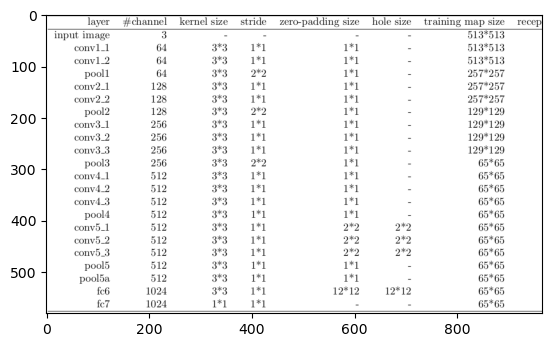

In [26]:
IX = 19

# img_path = valid_imgs_paths[IX]
img_path = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/img/1601.04798v3.1.png'
img_name = path2name(img_path)
img = load_image(img_path)
plt.imshow(img)
print(img.shape, img_path)

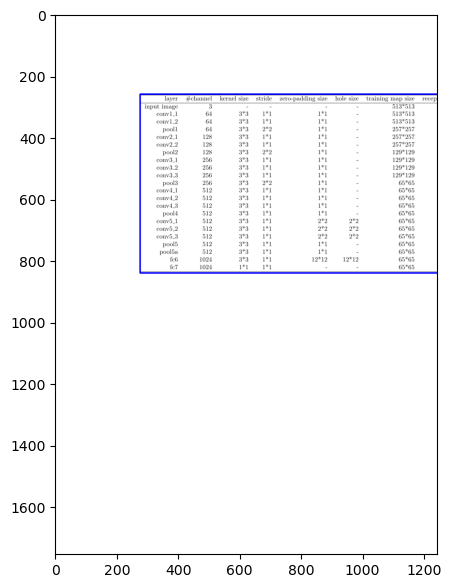

Shape: (1754, 1241, 3)
Top left: (257, 276)
Bottom right: (839, 1244)


In [27]:
def get_table_pos(pdf_path, display=False):
    imgs_pdf = convert_from_path(pdf_path, 150)
    assert len(imgs_pdf) == 1, 'There is more than one pdf image'
    img_pdf = np.array(imgs_pdf[0])
    gray = cv.cvtColor(img_pdf, cv.COLOR_RGB2GRAY)
    thresh, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    coords = cv.findNonZero(gray)
    x, y, w, h = cv.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    if display:
        top_left = (round(left), round(top))
        bottom_right = (round(right), round(bottom))
        cv.rectangle(img_pdf, top_left, bottom_right, (0, 0, 255), 3)
        view_imgs([img_pdf])
        print('Shape: ' + str(img_pdf.shape))
    return left, top, right, bottom

img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')

left, top, right, bottom = get_table_pos(img_pdf_path, True)
print(f'Top left: ({top}, {left})')
print(f'Bottom right: ({bottom}, {right})')

In [28]:
def coord_pdf2img(x, y, left, top):
    ratio = 1754 / 842
    new_x = x * ratio - left
    new_y = 1754 - y * ratio - top
    return new_x, new_y

def read_chunk(chunk_path, left, top, display=False):
    Chunks = []
    with open(chunk_path) as f:
      data = json.load(f)
      chunks = data['chunks']
      #print(len(chunks))
      for c in chunks:
          pos = c['pos']
          l,r,t,b = int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])
          if display: print('OG       :', l,t,r,b, '--', c['text'])
          l,t = coord_pdf2img(l,t, left, top)
          r,b = coord_pdf2img(r,b, left, top)
          if display: print('Converted:', int(l), int(t), int(r), int(b))
          if t > b: t, b = b, t
          Chunks.append((c['text'], [int(l), int(t)-5, int(r), int(b)]))
    return Chunks

In [37]:
img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')

chunks = read_chunk(img_chunk_path, left, top)
len(chunks)

207

In [38]:
def filter_visible_chunks(img, chunks):
    H, W, _ = img.shape
    chunks_flt = []
    for chunk in chunks:
        text, (l, t, r, b) = chunk
        if r <= 0 or b <= 0 or l >= W or t >= H: 
            continue
        chunks_flt.append(chunk)
    return chunks_flt

chunks = filter_visible_chunks(img, chunks)
len(chunks)

162

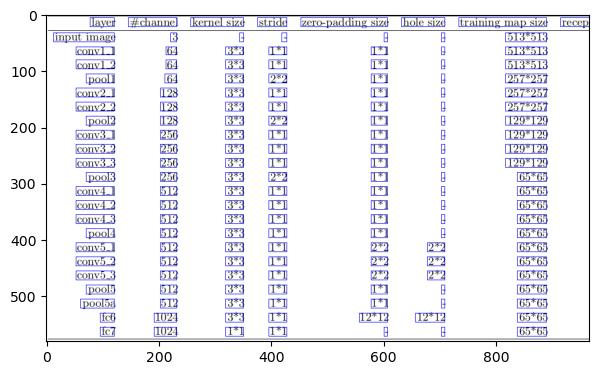

In [39]:
img_draw = img.copy()

for chunk in chunks:
    pos = chunk[1]
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    cv.rectangle(img_draw, left_top, bottom_right, (0, 0, 255), 1)

view_imgs([img_draw])

In [43]:
def read_struct(struct_path, chunks_text):
    cell_list = []
    n_rows, n_cols = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['tex']
            if content == '' or content not in chunks_text: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            n_rows = max(n_rows, er+1)
            n_cols = max(n_cols, ec+1)
            cell_list.append({
                'id': id,
                'range': [sr, er, sc, ec],
                'content': content
            })
    cell_list = sorted(cell_list, key=itemgetter('id'))
    return cell_list, n_rows, n_cols

chunks_text = [c[0] for c in chunks]
TRAIN_STRUCT_DIR = os.path.join(SCITSR_TRAIN, 'structure')
img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
cells, nrows, ncols = read_struct(img_struct_path, chunks_text)

In [44]:
print(img_struct_path)

/Users/longhoang/Developer/table-reg/data/SciTSR/train/structure/1601.04798v3.1.json


In [45]:
cells

[{'id': 0, 'range': [0, 0, 0, 0], 'content': 'layer'},
 {'id': 2, 'range': [0, 0, 2, 2], 'content': 'kernel size'},
 {'id': 3, 'range': [0, 0, 3, 3], 'content': 'stride'},
 {'id': 4, 'range': [0, 0, 4, 4], 'content': 'zero-padding size'},
 {'id': 5, 'range': [0, 0, 5, 5], 'content': 'hole size'},
 {'id': 6, 'range': [0, 0, 6, 6], 'content': 'training map size'},
 {'id': 9, 'range': [1, 1, 0, 0], 'content': 'input image'},
 {'id': 10, 'range': [1, 1, 1, 1], 'content': '3'},
 {'id': 11, 'range': [1, 1, 2, 2], 'content': '-'},
 {'id': 12, 'range': [1, 1, 3, 3], 'content': '-'},
 {'id': 13, 'range': [1, 1, 4, 4], 'content': '-'},
 {'id': 14, 'range': [1, 1, 5, 5], 'content': '-'},
 {'id': 15, 'range': [1, 1, 6, 6], 'content': '513*513'},
 {'id': 17, 'range': [1, 1, 8, 8], 'content': '-'},
 {'id': 19, 'range': [2, 2, 1, 1], 'content': '64'},
 {'id': 20, 'range': [2, 2, 2, 2], 'content': '3*3'},
 {'id': 21, 'range': [2, 2, 3, 3], 'content': '1*1'},
 {'id': 22, 'range': [2, 2, 4, 4], 'content

In [46]:
nrows, ncols

(23, 9)

In [11]:
# TRAIN_REL_DIR = os.path.join(SCITSR_TRAIN, 'rel')
# img_rel_path = img_path.replace('png', 'rel').replace('img', 'rel')

In [12]:
def create_label(cells, nrows, ncols, img_path=None):
    D = np.zeros((nrows-1, ncols), dtype=np.uint8) # (down) matrix of merging rows
    R = np.zeros((nrows, ncols-1), dtype=np.uint8) # (right) matrix of merging columns
    for c in cells:
        sr, er, sc, ec = c['range']
        if sr > er or sc > ec:
            print(f"Cell number {c['id']} has invalid rows or columns: {sr, er, sc, ec}")
            if img_path: 
                print("  Image path:", img_path)
            continue
        if sr < er and sc == ec:
            D[sr:er, sc] = 1
        if sr == er and sc < ec:
            R[sr, sc:ec] = 1
        if sr < er and sc < ec:
            print(f"Cell number {c['id']} spans both rows and columns")
    return D, R

D, R = create_label(cells, nrows, ncols)

In [13]:
D, D.shape

(array([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8),
 (11, 8))

In [14]:
R, R.shape

(array([[0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], dtype=uint8),
 (12, 7))

In [15]:
# load back split labels
SPLIT_LABEL_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/split_label.json'
with open(SPLIT_LABEL_PATH, 'r') as f:
    split_labels = json.load(f)

len(split_labels)

11971

In [16]:
LABELS = {}
LABELS[img_name] = {
    'rows': split_labels[img_name]['rows'],
    'columns': split_labels[img_name]['columns'],
    'h_matrix': R.tolist(),
    'v_matrix': D.tolist()
}

In [19]:
label = LABELS[img_name]
len(label['rows']), len(label['columns']), np.array(label['h_matrix']).shape, np.array(label['v_matrix']).shape

(311, 741, (12, 7), (11, 8))

In [17]:
TRAIN_LABEL_PATH = os.path.join(SCITSR_TRAIN, 'label')
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)

# with open(os.path.join(TRAIN_LABEL_PATH, 'merge_label.json'), 'w') as f:
#     json.dump(LABELS, f)

In [18]:
# test correctness
MERGE_LABEL_PATH = os.path.join(TRAIN_LABEL_PATH, 'merge_label.json')
with open(MERGE_LABEL_PATH, 'r') as f:
    data = json.load(f)

data = data[img_name]
len(data['rows']), len(data['columns']), np.array(data['h_matrix']).shape, np.array(data['v_matrix']).shape

(311, 741, (12, 7), (11, 8))

Putting everything together

In [121]:
def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [122]:
def prepare_merge_labels(folder_path: str, json_path: str, split_label_path: str):
    '''
    Params:
        folder_path -- string, path to image folder either train or test folder
        json_path -- string, path to json file to write ground truth into
        split_label_path -- string, path to the json file 
                            which stores ground truths for split module
    Returns:
        None
    '''
    # load split labels
    with open(split_label_path, 'r') as f:
        split_labels = json.load(f)
    print(f"Loaded {len(split_labels)} labels for Split module")

    imgs_paths = [os.path.join(folder_path, p) for p in os.listdir(folder_path)]
    valid_imgs_paths = [p for p in imgs_paths if cv.imread(p) is not None]
    print(f"Found {len(valid_imgs_paths)} image paths out of {len(imgs_paths)} paths")

    LABELS = {}
    for i, img_path in enumerate(valid_imgs_paths):
        img = load_image(img_path)
        # view_imgs([img])
        img_name = path2name(img_path)
        # read structure file to get cell locations
        img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
        cells, nrows, ncols = read_struct(img_struct_path)
        D, R = create_label(cells, nrows, ncols, img_path)
        LABELS[img_name] = {
            'rows': split_labels[img_name]['rows'],
            'columns': split_labels[img_name]['columns'],
            'h_matrix': R.tolist(),
            'v_matrix': D.tolist()
        }
        if (i + 1) % 100 == 0:
            print(f"Got labels for {i+1} images!")
    
    with open(json_path, 'w') as f:
        json.dump(LABELS, f)
    return None

In [123]:
prepare_merge_labels(TRAIN_IMG_DIR, MERGE_LABEL_PATH, SPLIT_LABEL_PATH)

Loaded 11971 labels for Split module


libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error


Found 11971 image paths out of 12000 paths
Got labels for 100 images!
Got labels for 200 images!
Got labels for 300 images!
Got labels for 400 images!
Got labels for 500 images!
Got labels for 600 images!
Got labels for 700 images!
Got labels for 800 images!
Got labels for 900 images!
Got labels for 1000 images!
Got labels for 1100 images!
Got labels for 1200 images!
Got labels for 1300 images!
Got labels for 1400 images!
Got labels for 1500 images!
Got labels for 1600 images!
Got labels for 1700 images!
Got labels for 1800 images!
Got labels for 1900 images!
Got labels for 2000 images!
Got labels for 2100 images!
Got labels for 2200 images!
Got labels for 2300 images!
Got labels for 2400 images!
Got labels for 2500 images!
Got labels for 2600 images!
Got labels for 2700 images!
Got labels for 2800 images!
Got labels for 2900 images!
Got labels for 3000 images!
Got labels for 3100 images!
Got labels for 3200 images!
Got labels for 3300 images!
Got labels for 3400 images!
Got labels for

In [124]:
with open(MERGE_LABEL_PATH, 'r') as f:
    merge_labels = json.load(f)
len(merge_labels)

11971